In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from conditionalconformal.synthetic_data import generate_cqr_data, indicator_matrix
from conditionalconformal import CondConf

In [3]:
# generate data
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=1, n_calib=2000)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# nominal level is 0.9
alpha = 0.1

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

# coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn_groups(x):
    return indicator_matrix(x, disc)

# coverage on Gaussians with mu=loc and sd=scale 
# scale = 1 for x != [1.5, 3.5]
eval_locs = [1.5, 3.5]
eval_scale = 0.2

other_locs = [0.5, 2.5, 4.5]
other_scale = 1

def phi_fn_shifts(x):
    shifts = [norm.pdf(x, loc=loc, scale=eval_scale).reshape(-1,1)
                   for loc in eval_locs]
    shifts.extend([norm.pdf(x, loc=loc, scale=other_scale).reshape(-1,1)
                   for loc in other_locs])
    shifts.append(np.ones((x.shape[0], 1)))
    return np.concatenate(shifts, axis=1)

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))

In [32]:
if experiment == 'groups':
    phi_fn = phi_fn_groups
    infinite_params = {}
elif experiment == 'shifts':
    phi_fn = phi_fn_shifts
    infinite_params = {}
elif experiment == 'agnostic':
    phi_fn = phi_fn_intercept
    infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}
else:
    raise ValueError(f"Invalid value for experiment: {experiment}.")

cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(x_calib, y_calib)

n_test = len(x_test)

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))

lbs_r = np.zeros((n_test,))
ubs_r = np.zeros((n_test,))

for i,x_t in enumerate(tqdm(x_test)):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb, exact=True, randomize=True)
    lbs[i] = res[0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub, exact=True, randomize=True)
    ubs[i] = res[1]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 443.40it/s]


In [ ]:
import torch
from torch.optim import Adam
from scipy.stats import norm
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.cdf import get_cdf, quantile_regression, get_mean_from_nf, compute_marginal, get_cdf_from_nf
from NCP.nn.losses import CMELoss
from NCP.metrics import smooth_cdf
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from scipy.stats import laplace, cauchy, bernoulli, pareto
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint


X_train_torch = frnp(x_train_final)
Y_train_torch = frnp(y_train_final)
X_val_torch = frnp(x_calib)
Y_val_torch = frnp(y_calib)
train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)
#y discretisation for computing cdf
spread = np.max(y_train_final) - np.min(y_train_final)
p1, p99 = np.min(y_train_final), np.max(y_train_final)
y_discr, step = np.linspace(p1-0.1*spread, p99+0.1*spread, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NEXP=1

best_models = {}

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 2e-2
    epochs = int(5e3)
    output_shape = 2000

    MLP_kwargs_U = {
        'input_shape': x_train_final.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size': 128,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    MLP_kwargs_V = {
        'input_shape': y_train_final.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size':128,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, 
                      U_operator_kwargs=MLP_kwargs_U, 
                      V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        Adam,
        {'lr':1e-3},
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[early_stop, checkpoint_callback])

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

In [ ]:
pred_test = best_models[0].conditional_expectation(x_test, y_train_final, postprocess='whitening').reshape(-1, 1)
pred_quantiles = np.zeros((x_test.shape[0], 2))
for i, xi in enumerate(tqdm(x_test)):
    pred_quantiles[i] = quantile_regression(best_models[0], torch.Tensor([xi]),
                                            y_discr_torch, alpha = 0.01, 
                                            postprocess='whitening', marginal=marginal, 
                                            model_type='NCP')

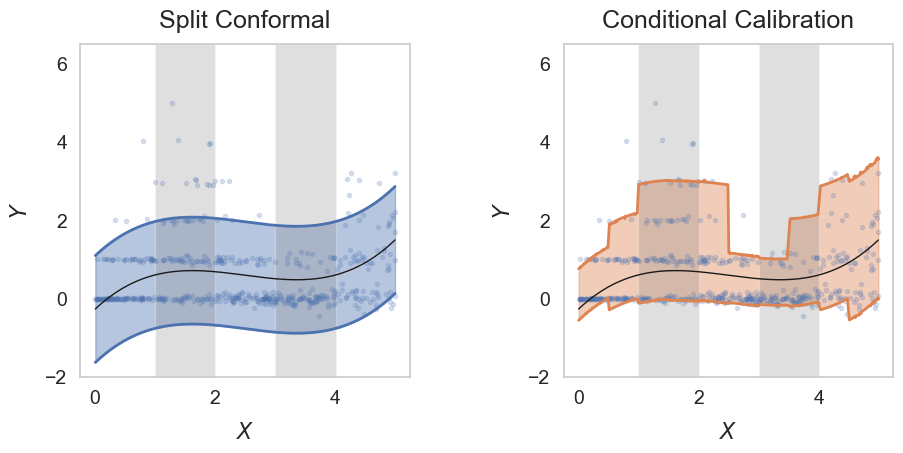

In [33]:
# plot predictions

q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(10.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb = lbs[sort_order]
ub = ubs[sort_order]
lb_r = lbs_r[sort_order]
ub_r = ubs_r[sort_order]


ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)
ax1.fill_between(x_test_s.flatten(), y_test_hat - q, y_test_hat + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,6.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)

ax2 = fig.add_subplot(1, 2, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb, 
                 ub, 
                 color=cp[1], alpha=0.4, label='conditional calibration')

ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)

ax3  = fig.add_subplot(1,1,3)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, pred_test, color='k', lw=1)
ax2.plot(x_test_s, pred_quantiles, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), pred_quantiles[:,0], 
                 pred_quantiles[:,1], 
                 color=cp[1], alpha=0.4, label='NCP')

ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)


plt.tight_layout(pad=5)